# Notebook #5: Series temporales: predicción a futuro de la población

In [13]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [15]:
df_poblacion.head()

,anio,poblacion
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [16]:
df_poblacion.tail()

,anio,poblacion
59,2019,10881882
60,2020,10999664
61,2021,11117873
62,2022,11228821
63,2023,11332972


In [17]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [18]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [19]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [20]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. Sin embargo, entre el 1990-2000 esta línea que muestra un ascenso casi lineal empieza a mostrar un cambio en su fuerza de aumento. Lo cuál queda más claro a partir del 2010.

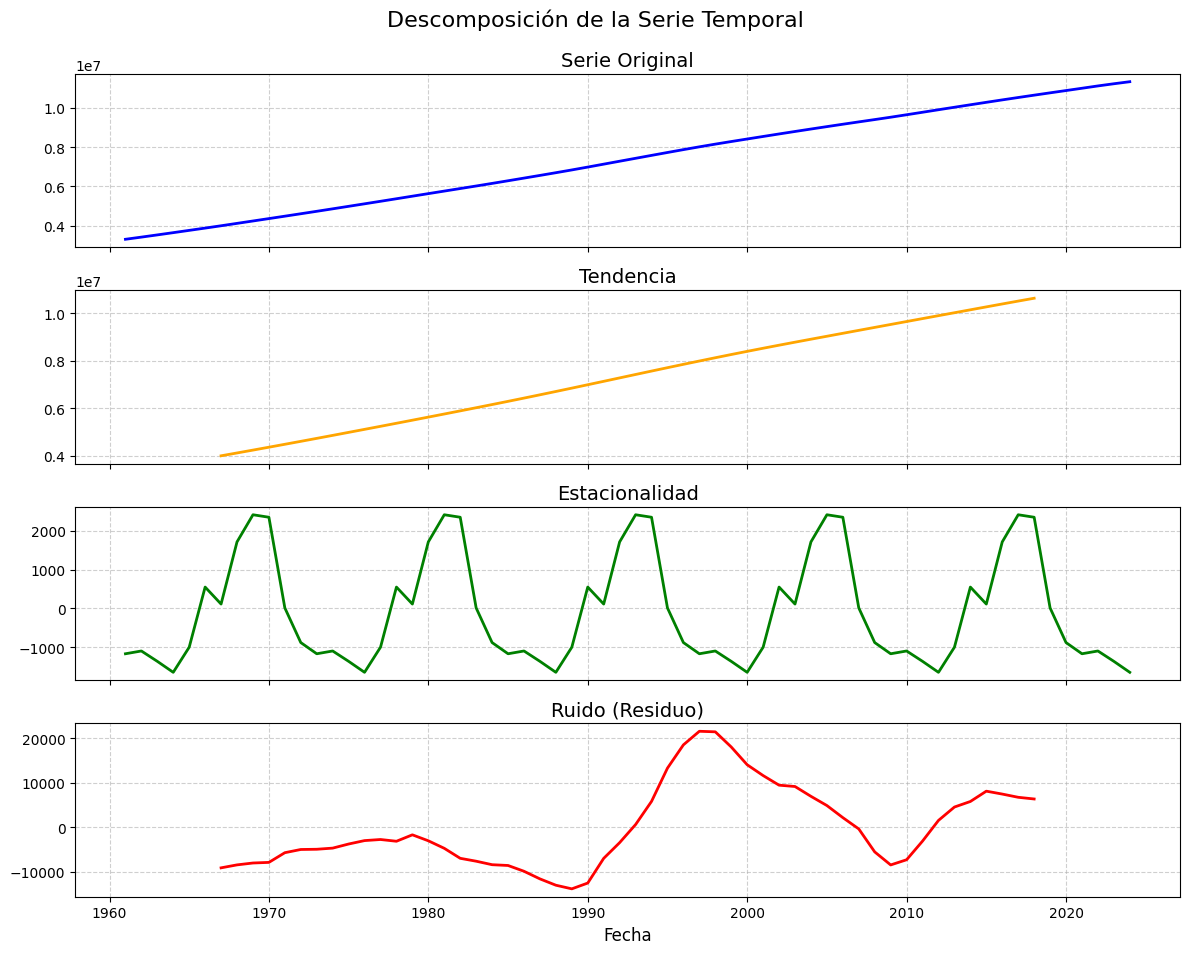

In [21]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

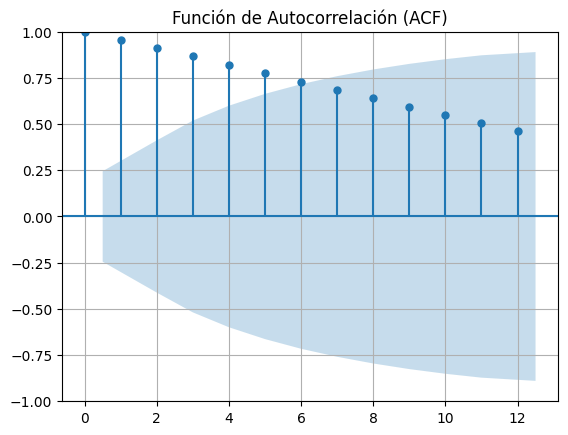

<Figure size 1200x1000 with 0 Axes>

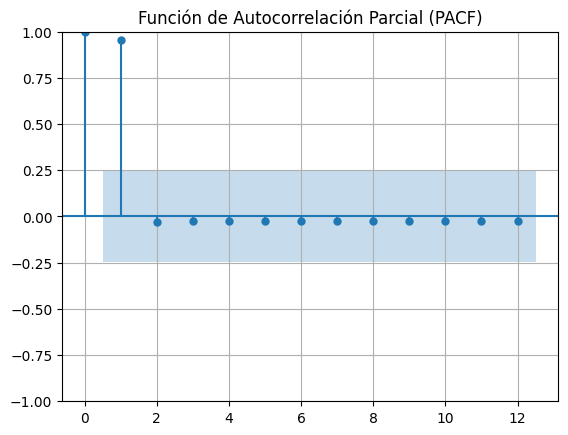

In [22]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Hasta el lag número 6 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del sexto lag, las correlaciones se adentran al intervalo de confianza.

3. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa, indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [23]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


## Prophet

In [24]:
df_poblacion.columns = ['ds', 'y']

In [25]:
df_poblacion.head()

,ds,y
0,1960-12-31,3298021
1,1961-12-31,3408415
2,1962-12-31,3521164
3,1963-12-31,3635798
4,1964-12-31,3752313


In [26]:
df_poblacion.tail()

,ds,y
59,2019-12-31,10881882
60,2020-12-31,10999664
61,2021-12-31,11117873
62,2022-12-31,11228821
63,2023-12-31,11332972


In [27]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-31,207291,3289957,3302779,207291,207291,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3296446
1,1961-12-31,321164,3402249,3416061,321164,321164,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,3409155
2,1962-12-31,435036,3514932,3528505,435036,435036,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,3521896
3,1963-12-31,548939,3628417,3642051,548939,548939,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,3635403
4,1964-12-31,663154,3746079,3759619,663154,663154,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3752309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2021-12-31,8029613,11110402,11124214,8029613,8029613,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,11117604
62,2022-12-31,8150000,11229951,11243499,8150000,8150000,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,11236860
63,2023-12-31,8270387,11350381,11363718,8270387,8270387,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,11356851
64,2024-12-31,8391104,11473016,11486851,8389747,8392048,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,11480258


In [28]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2021-12-31,11117604,11110615,11124129
62,2022-12-31,11236860,11230002,11243284
63,2023-12-31,11356851,11349958,11363700
64,2024-12-31,11480258,11473699,11487338
65,2025-12-31,11599481,11591540,11607525


In [29]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df['poblacion'] = df_poblacion['y']
df = df[df['poblacion'].notnull() & df['yhat'].notnull()]
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,poblacion
59,2019-12-31,10874974,10868264,10881653,10881882
60,2020-12-31,10998381,10991530,11004934,10999664
61,2021-12-31,11117604,11110615,11124129,11117873
62,2022-12-31,11236860,11230002,11243284,11228821
63,2023-12-31,11356851,11349958,11363700,11332972


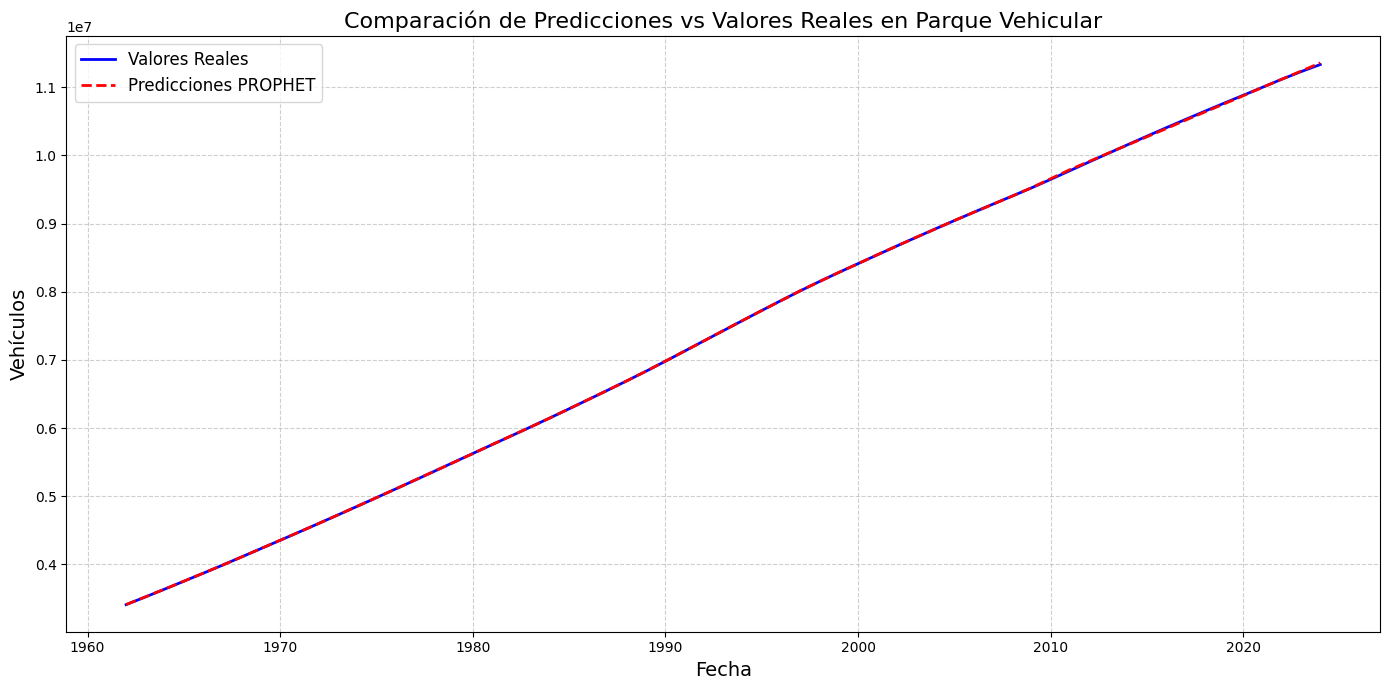

In [30]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df[1:], x="ds", y="poblacion", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=df[1:], x="ds", y="yhat", label="Predicciones PROPHET", color="red", linestyle="--", linewidth=2) # predicciones
plt.title("Comparación de Predicciones vs Valores Reales en Parque Vehicular", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Vehículos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

In [31]:
# Seleccionar las columnas relevantes
y_real = df['poblacion']
y_pred = df['yhat']

# Cálculo de MAE
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimir los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")               
print(f"RMSE: {rmse}")

MAE: 2742.6311766910076
MAPE: 0.03%
RMSE: 5247.101222229977


In [32]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [33]:
plot_components_plotly(m, forecast)

In [34]:
predicciones = forecast[['ds', 'yhat']]
predicciones.columns = ['fecha', 'predicciones']

In [35]:
predicciones.to_csv('../../Datos/datos_predichos/df_poblacion_predicciones.csv')